In [1]:
%config InlineBackend.figure_format = "svg"

# Data visualization imports
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

# Data processing imports
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
import pandas as pd
import numpy as np

## Import clustered data

In [2]:
df = pd.read_csv("my_data/clustered_data.csv")
df

x        y        z  groove  tread     depth
0       0.15000 -0.12917  0.42000      -1   True  2.252963
1       0.15000 -0.12917  0.42000      -1   True  2.252963
2       0.14988 -0.12882  0.42000      -1   True  2.539181
3       0.14988 -0.12882  0.42000      -1   True  2.539181
4       0.14882 -0.13181  0.41882      -1   True  1.286047
...         ...      ...      ...     ...    ...       ...
195176 -0.13118  0.02294  0.27167       2  False  3.290156
195177 -0.13118  0.02287  0.27176       2  False  3.393917
195178 -0.13000  0.02287  0.27176       2  False  3.116971
195179 -0.12412  0.02271  0.27176       2  False  3.018646
195180 -0.12294  0.02276  0.27176       2  False  3.002566

[195181 rows x 6 columns]

# TASK 3 and 4: Estimate data from groove clusters and visualize groove bottoms

We have already clustered our data into grooves and tread.

We now want to estimate the depth component of our data. I used the following approach:
- Estimate the axis of rotation of the tire
- Calculate distances of each point from the rotation axis to get the depth

We can see that the `xz` cross-sections of our data follow more or less a circular pattern. We will fit a circle to this cross-section data to estimate the rotation axis.

However, the point cloud data is noisy and contains points with various different radii. This can be improved by filtering the dataset and using only the groove clusters to compute this circle fit, as the radii variation will be smaller.

Nevertheless, the groove clusters also contain points of different radii, and so we can improve this method even further by filtering separating the bottom of the grooves from the groove clusters:

## Part 1: Filtering data to get bottom of each cluster (includes TASK 4)

To get the bottom of each cluster, we will look at `yz` cross-sections of our grooves. They are approximately U shaped, with the optimum of the curve representing the tread bottom.

As such, I use the following procedure:
- Separate the data into various `yz` cross-sections
- At each cross-section, fit a cubic function to the U curve and find its peak
- Select data-points close to that peak as the bottom of the groove

In [3]:
def cubic_fit(X, y):
    # Define cubic function to optimize
    func = lambda x, a, b, c, d: a*x**3 + b*x**2 + c*x + d
    
    # Fit curve and get best parameters
    params, _ = curve_fit(func, X, y)
    
    # Define function from parameters
    a, b, c, d = params
    f = lambda x: a*x**3 + b*x**2 + c*x + d
    
    return f


def get_peaks(x, y):
    # Find peak indexes
    peaks, _ = find_peaks(y)
    
    # Select the only peak
    peak = peaks[0]
    
    # Calculate x and y values for the peaks
    peak, peak_value = x.iloc[peak], y.iloc[peak]
    
    return peak, peak_value


def get_bottom_cross_section_points(cross_df):
    # Sort dataframe by y values
    cross_df = cross_df.sort_values(by="y")
    
    # Get the y and z components
    y, z = cross_df.y, cross_df.z
    
    # Fit cubic curve to data
    curve = cubic_fit(y, z)
    
    # Find cubic curve peaks
    _, peak_value = get_peaks(y, curve(y))
    
    # Collect indices for datapoint within 0.5mm from peak
    bottom_points = cross_df.query(f"z >= {peak_value} - 0.0005 and z <= {peak_value} + 0.0005")
    bottom_idx = bottom_points.index
    
    return bottom_idx


# Create a new dataset feature called 'bottom': states whether a point belongs to the bottom of a groove
df["bottom"] = False

# Iterate grooves
for g in df.query("groove != -1").groove.unique():
    
    # Filter dataframe per groove
    groove_df = df.query(f"groove == {g}")
    
    # Calculate cross-sections per groove
    x = np.linspace(groove_df.x.min(), groove_df.x.max(), 100)
    x_sections = [(x[i], x[i+1]) for i in range(x.shape[0]-1)]
        
    # Iterate cross-sections
    for l, u in x_sections:
        
        # Filter dataframe for groove and cross-section
        cross_df = groove_df.query(f"x >= {l} and x <= {u}")
    
        # Get the bottom indices
        idx = get_bottom_cross_section_points(cross_df)
    
        # Update bottom fature
        df.loc[idx, "bottom"] = True
    
df.query("bottom")

x        y        z  groove  tread     depth  bottom
147936  0.14765 -0.05471  0.41022       0  False  6.646565    True
147937  0.14765 -0.05471  0.41022       0  False  6.646565    True
147940  0.14765 -0.05353  0.40975       0  False  6.307141    True
147942  0.14765 -0.05353  0.40975       0  False  6.307141    True
147943  0.14765 -0.05353  0.40975       0  False  6.307141    True
...         ...      ...      ...     ...    ...       ...     ...
194024 -0.11471  0.01941  0.27505       2  False  6.498265    True
194026 -0.11353  0.01941  0.27507       2  False  6.345378    True
194028 -0.11235  0.01941  0.27512       2  False  6.401691    True
194052 -0.10176  0.01941  0.27523       2  False  6.052873    True
194056 -0.09941  0.01941  0.27528       2  False  5.968527    True

[6828 rows x 7 columns]

Now that we have filtered the bottom of the grooves, let's plot them to check the separation:

In [4]:
# Get groove and bottom data
groove_df = df.query("groove != -1 and not bottom")
bottom_df = df.query("bottom")

# Plot the data
data = [
    go.Scatter3d(x=groove_df.x, y=groove_df.y, z=groove_df.z, name="grooves", mode="markers", marker=dict(size=2, color="orange")),
    go.Scatter3d(x=bottom_df.x, y=bottom_df.y, z=bottom_df.z, name="bottom", mode="markers", marker=dict(size=2, color="green")),
]
fig = go.Figure(data=data)
fig.update_layout(title="Groove bottom filtering", legend={'itemsizing': 'constant'})
fig.show()

Finally, let's save our new dataframe:

In [5]:
df.to_csv("my_data/groove-bottom.csv", index=False)

## Part 2: Estimating tire rotation axis

Now that we have the bottom of the grooves filtered, we can finally fit a circle curve to their data in order to estimate the rotation axis of the tire.

First, let's look at an `xz` projection of our data:

In [6]:
# Select all groove data
groove_df = df.query("groove != -1")

# Plot the data
plt.title("Groove bottom xz point cloud projection")
plt.scatter(x=groove_df.x, y=groove_df.z, label="grooves", s=2)
plt.scatter(x=bottom_df.x, y=bottom_df.z, label="bottom", s=2)
plt.ylabel("z (m)")
plt.xlabel("x (m)")
plt.axis("equal")
plt.legend()
plt.show()

We can see from this plot that our bottom groove data has less radius variability, at the detriment of reducing the data points. It is possible that the data point reduction would lead to a worse performance in fitting this data to a circle. In any case, we will use the bottom data to estimate the rotation axis.

The equation for our circle will be given by:
$$ (x - x_0)^2 + (z - z_0)^2 = r^2 $$

Where (x_0, z_0) represent the coordinates of our axis of rotation and $r$ the radius of the circunference. In this case, we do not have the specifications of the tire, so we also have to estimate $r$. If we did have the specifications, we could improve our estimation of the rotation axis.

We can linearlize the equation above into the following equation:
$$ 2x_0x + 2z_0z + r^2 - x_0^2 - z_0^2 = x^2 + z^2 $$

This linearization makes it easier to use a `least_squares` method to extract the axis of rotation.

In [7]:
def circle_fit(X, y):
    # Function to fit to circle data
    f = lambda x, x0, y0, r: 2*x0*x + 2*y0*y + r**2 - x0**2 - y0**2
    
    # Get the A, B, C fitted parameters
    params, _ = curve_fit(f, X, X**2 + y**2, ftol=1e-12)
    x0, y0, r = params
    
    # Determine center and radius from parameters
    c, r = (x0, y0), np.abs(r)
    
    return c, r

c, r = circle_fit(bottom_df.x, bottom_df.z)
print(f"Tire rotation axis: ({c[0]:.5f}, {c[1]:.5f}) m")
print(f"Tire to groove bottom radius: {r:.5f} m")

Tire rotation axis: (-0.11267, 0.60346) m
Tire to groove bottom radius: 0.32679 m


With these parameters estimated, let's visually check how well it fits the data:

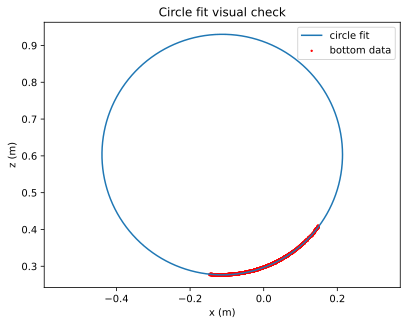

In [8]:
# Create circle data
angles = np.linspace(0, 2*np.pi, 1000)
circle_x = c[0] + r * np.cos(angles)
circle_y = c[1] + r * np.sin(angles)

# Plot the data
plt.title("Circle fit visual check")
plt.plot(circle_x, circle_y, label="circle fit")
plt.scatter(bottom_df.x, bottom_df.z, label="bottom data", color="red", s=2)
plt.xlabel("x (m)")
plt.ylabel("z (m)")
plt.axis("equal")
plt.legend()
plt.show()

## Part 3: Estimate depth feature

In [9]:
# Calculate distance to rotation axis in meters
dist = np.sqrt( (c[0] - df.x)**2 + (c[1] - df.z)**2 )

# Calculate depth in mm
depth = (dist.max() - dist) * 1000
df["my_depth"] = depth

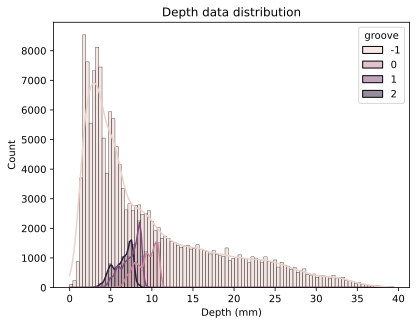

In [10]:
# Plot depth distribution
plt.title("Depth data distribution")
sns.histplot(data=df, x="my_depth", hue="groove", bins=100, kde=True)
plt.xlabel("Depth (mm)")
plt.show()